Pmdarima is a statistical library designed to fill teh void in Pyhon's TS analysis capabilities.

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 15.5 MB/s 
     |████████████████████████████████| 9.9 MB 52.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

#Dataset 1: Facebook Stock Market Performance 

In [ ]:
df = pd.read_csv(r'/content/FB.csv', parse_dates = True)

In [ ]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
1,2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2,2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
3,2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
4,2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600
5,2014-12-15,78.459999,78.580002,76.559998,76.989998,76.989998,29396500
6,2014-12-16,76.190002,77.389999,74.589996,74.690002,74.690002,31554600
7,2014-12-17,75.010002,76.410004,74.900002,76.110001,76.110001,29203900
8,2014-12-18,76.889999,78.400002,76.510002,78.400002,78.400002,34222100
9,2014-12-19,78.750000,80.000000,78.330002,79.879997,79.879997,43335000


### a.	Plot a histogram and compare the values with N (0,1). 

Perform Exploratory Data Analysis using line, histogram and kernel density estimation (KDE) of the closing price of the stocks. EDA is the process of using a graphical representation to discover and investigate patterns within data.


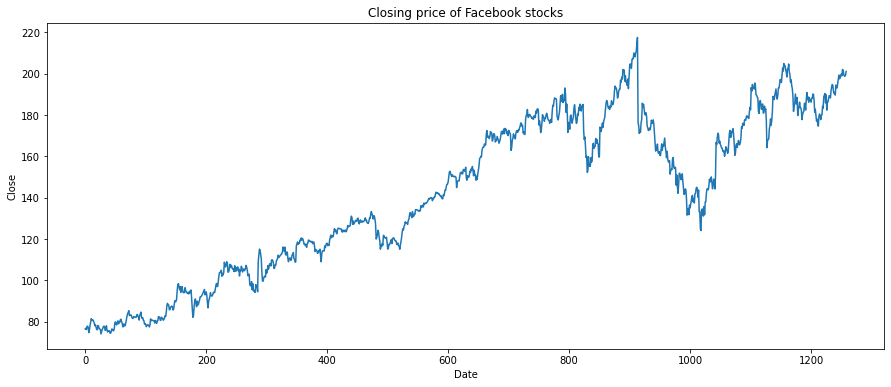

In [ ]:
df["Close"].plot(figsize=(15, 6))
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Closing price of Facebook stocks")
plt.show()

KDE is a nonparametric way to estimate the probability density function (PDF) of a random variable.

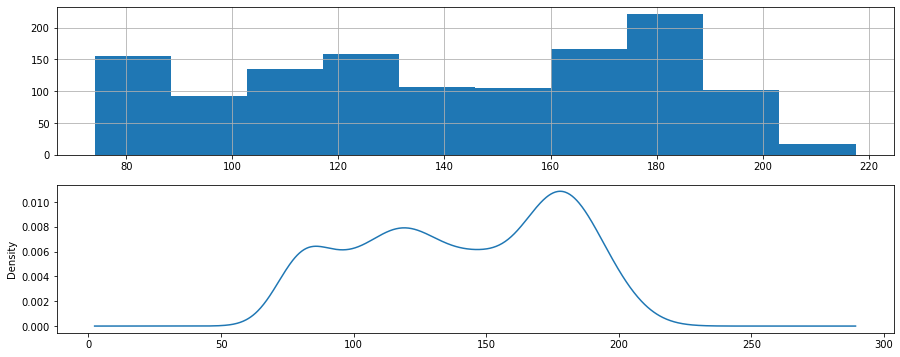

In [ ]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["Close"].hist()
plt.subplot(212)
df["Close"].plot(kind='kde')
plt.show()

###b.	Check for Stationarity. 

Define the TS evaluation function.

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MSE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

ADF test function to check for stationary data.

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df['Close' ],'Close')

Results of Dickey-Fuller Test for column: Close
Test Statistic                   -1.338096
p-value                           0.611568
No Lags Used                      0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Close is non-stationary and auto-arima handles this internally.

###c.	State the coefficients which must be used for the appropriate model selected. 

Model training will be done only for the Close column from the dataset. Make a copy of the data and perform the test/train split.

The train will have all the data except the last 30 days and test will contain only the last 30 days to evaluate against predictions.

In [ ]:
X = df[['Close' ]]
train, test = X[0:-30], X[-30:]

The pmdarima modeule will help us to identify p, d, q without the hassle of looking at the plot.

In [ ]:
stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=7, max_q=7, seasonal=False,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5926.792, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5929.302, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5930.825, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5930.810, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5928.648, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5928.521, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5930.139, Time=0.94 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5932.491, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5932.541, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5928.972, Time=2.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5927.184, Time=0.36 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 7.104 seconds


In [ ]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1229
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2959.396
Date:                Tue, 15 Nov 2022   AIC                           5926.792
Time:                        05:48:26   BIC                           5947.245
Sample:                             0   HQIC                          5934.488
                               - 1229                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0122      0.012      1.046      0.296      -0.011       0.035
ar.L1          0.8631      0.087      9.910      0.000       0.692       1.034
ma.L1         -0.8999      0.076    -11.855      0.000      -1.049      -0.751
sigma2         7.2569      0.083     87.805      0.000       7.095       7.419
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):            112080.53
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               4.99   Skew:                            -2.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto-ARIMA says **ARIMA(1,1,1)** is the optimal selection for the dataset. 

Forecast both results and the confidence for the next 30 days and store it in a DataFrame.

**Confidence** is the range of values you expect your estimate to fall between if you redo your test, within a certain level of confidence.

**return_conf_int=True:** Whether to get the confidence intervals of the forecasts.

###d.	Calculate the evaluation metrics (MSE, RMSE, MAPE and R2). 

In [ ]:
forecast,conf_int = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])

In [ ]:
df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
df_conf["new_index"] = range(1229, 1259)
df_conf = df_conf.set_index("new_index")

In [ ]:
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 73.01967210398398
MSE is : 7.728337069007178
RMSE is : 8.54515489057887
MAPE is : 3.918455774397025
R2 is : -2.9895373916905834



###e.	Forecast the future values and plot Confidence Interval Upper bound and Confidence Interval Lower bound with respect to train, test and predicted. 

Rearrange the indexes for the plots to align.

In [ ]:
forecast["new_index"] = range(1229, 1259)
forecast = forecast.set_index("new_index")

Plot the results with confidence bounds.

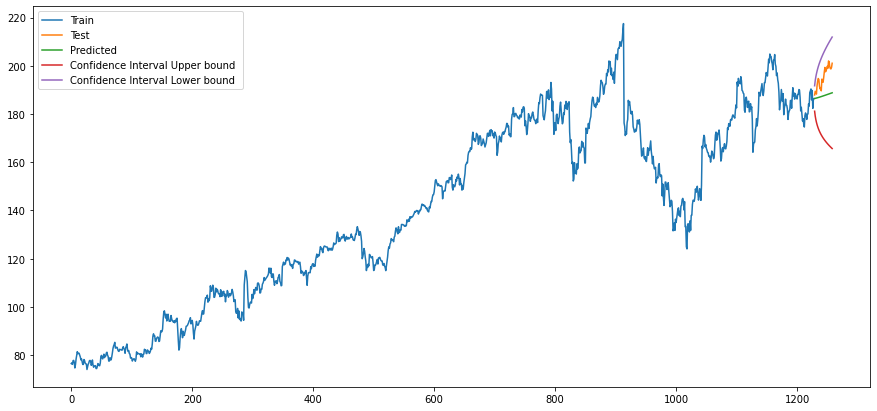

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train, label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

###f.	Analyse the actual data with predicted based on the plots: 
i.	Standardize Residual  	

ii.	Histogram plus estimated density

iii. Normal Q-Q  	 	

iv.	Correlogram 


Plot the diagnostic Plot.

**Standardized Residual:** It's a measure of the strength of the difference between observed and expected values.

**Histogram plus estimated density:** KDE is a nonparametric way to estimate the probability density function (PDF) of a random variable.

**Normal Q-Q:** Q-Q plots let you check that the data meet the assumption of normality. They compare the distribution of your data to a normal distribution by plotting the quartiles of your data against the quartiles of a normal distribution. If your data are normally distributed then they should form an approximately straight line.

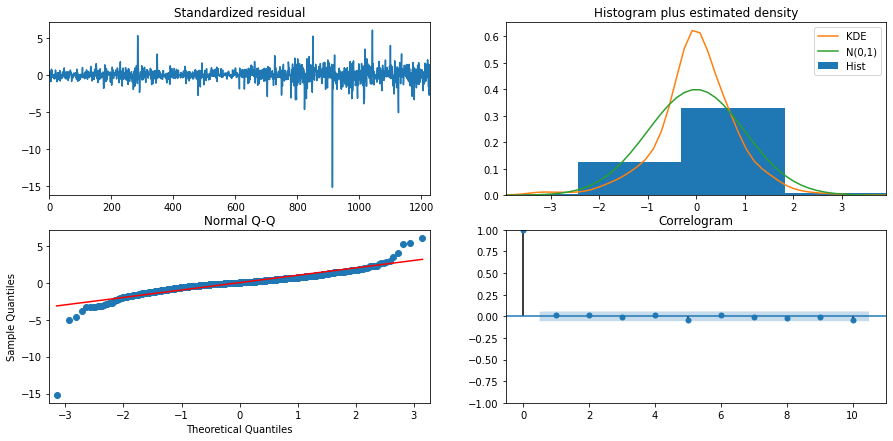

In [ ]:
stepwise_model.plot_diagnostics();

In [ ]:
forecast

,close_pred
new_index,
1229,186.433500
1230,186.491875
1231,186.554462
1232,186.620683
1233,186.690041
1234,186.762108
1235,186.836511
1236,186.912931
1237,186.991092


# Dataset 2: Monthly Milk Production

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv', parse_dates = True)

In [ ]:
df.head(5)

,Month,Monthly milk production: pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [ ]:
df.dropna(inplace=True)
df.rename(columns = {'Monthly milk production: pounds per cow':'Milk_Prod'}, inplace = True)
df.head(5)

,Month,Milk_Prod
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


###a.	Plot a histogram and compare the values with N (0,1). 

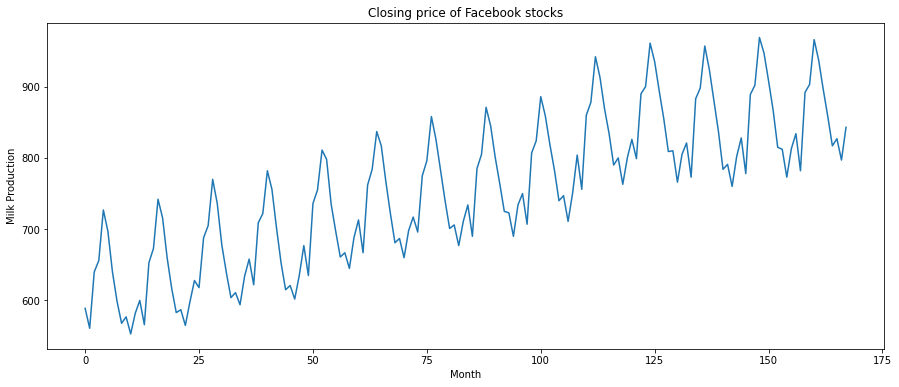

In [ ]:
df["Milk_Prod"].plot(figsize=(15, 6))
plt.xlabel("Month")
plt.ylabel("Milk Production")
plt.title("Closing price of Facebook stocks")
plt.show()

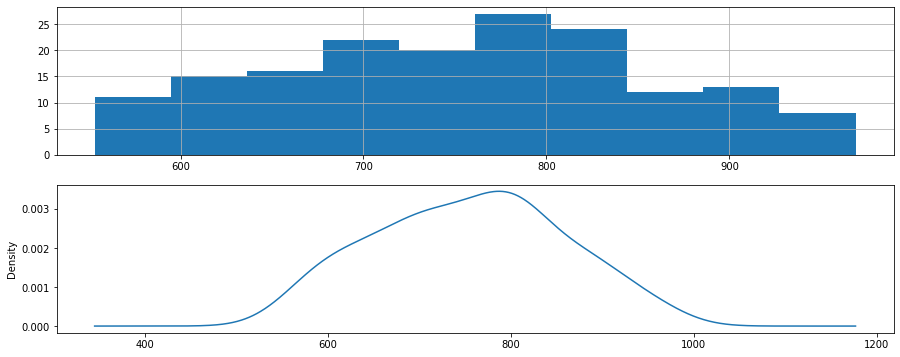

In [ ]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["Milk_Prod"].hist()
plt.subplot(212)
df["Milk_Prod"].plot(kind='kde')
plt.show()

###b.	Check for Stationarity. 

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MSE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df['Milk_Prod' ],'Milk_Prod')

Results of Dickey-Fuller Test for column: Milk_Prod
Test Statistic                  -1.303812
p-value                          0.627427
No Lags Used                    13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Close is non-stationary and auto-arima handles this internally.

###c.	State the coefficients which must be used for the appropriate model selected. 

In [ ]:
X = df[['Milk_Prod']]
train, test = X[0:-30], X[-30:]

In [ ]:
stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=7, max_q=7, seasonal=True,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)
print(stepwise_model)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1438.162, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1434.648, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1436.513, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1436.558, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1433.055, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.434 seconds
 ARIMA(0,1,0)(0,0,0)[0]          


In [ ]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  138
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -715.528
Date:                Tue, 15 Nov 2022   AIC                           1433.055
Time:                        08:01:44   BIC                           1435.975
Sample:                             0   HQIC                          1434.242
                                - 138                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2013.8117    292.256      6.891      0.000    1441.000    2586.624
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                11.40
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.60
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto-ARIMA says **ARIMA(0,1,0)** is the optimal selection for the dataset. 

Forecast both results and the confidence for the next 30 months and store it in a DataFrame.

**Confidence** is the range of values you expect your estimate to fall between if you redo your test, within a certain level of confidence.

**return_conf_int=True:** Whether to get the confidence intervals of the forecasts.

###d.	Calculate the evaluation metrics (MSE, RMSE, MAPE and R2). 

In [ ]:
forecast,conf_int = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['milk_prod_pred'])

In [ ]:
df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
df_conf["new_index"] = range(138, 168)
df_conf = df_conf.set_index("new_index")

In [ ]:
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 8889.466666666667
MSE is : 81.93333333333334
RMSE is : 94.28396823780099
MAPE is : 10.034072890491244
R2 is : -1.5745211058394069



###e.	Forecast the future values and plot Confidence Interval Upper bound and Confidence Interval Lower bound with respect to train, test and predicted. 

In [ ]:
forecast["new_index"] = range(138, 168)
forecast = forecast.set_index("new_index")

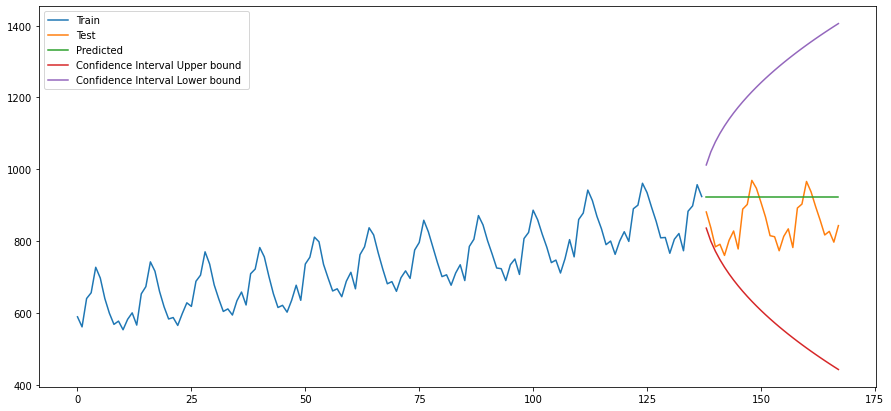

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train, label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

###f.	Analyse the actual data with predicted based on the plots: 
i.	Standardize Residual  	

ii.	Histogram plus estimated density 

iii.	Normal Q-Q  	 	

iv.	Correlogram 


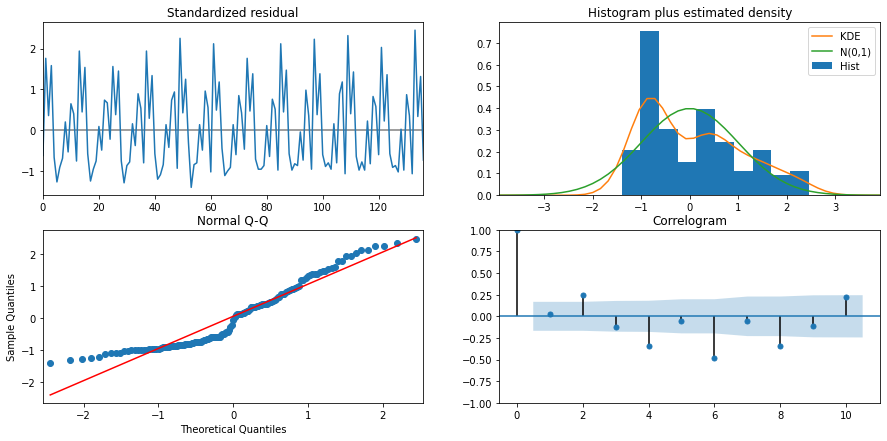

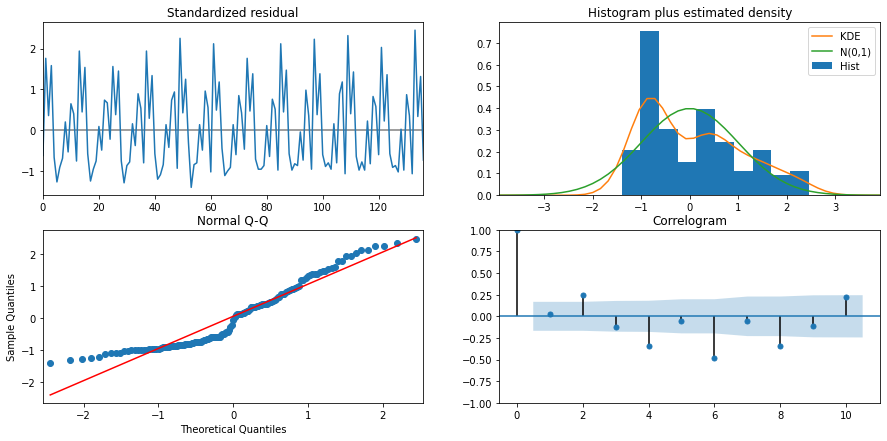

In [ ]:
stepwise_model.plot_diagnostics()

In [ ]:
forecast

,milk_prod_pred
new_index,
138,924.0
139,924.0
140,924.0
141,924.0
142,924.0
143,924.0
144,924.0
145,924.0
146,924.0
